In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

import anndata as ad
import scanpy as sc
from src.models import scETM
from src.trainers import UnsupervisedTrainer,prepare_for_transfer
from src import  evaluate
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="1"

Running Scanpy 1.8.2, on 2021-12-21 19:59.


In [2]:
mp_csvs = ['GSM2230757_human1_umifm_counts.csv', 'GSM2230758_human2_umifm_counts.csv','GSM2230759_human3_umifm_counts.csv', 'GSM2230760_human4_umifm_counts.csv']
mp_adatas = []
for fpath in mp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    mp_adatas.append(adata)
adata= ad.concat(mp_adatas, label="batch_indices")

In [3]:
#adata = sc.read_h5ad('data/dataset5.h5ad')

#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]


sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [4]:
batch_names = adata.obs['batch_indices'].value_counts().index.values
adatas = [adata[adata.obs['batch_indices'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_raw=compute_entropy(adata,batch_key='batch_indices',celltype_key='assigned_cluster')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


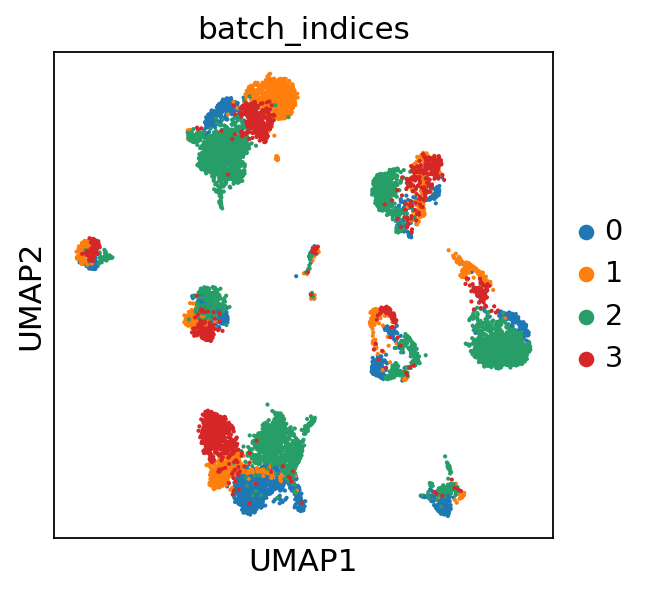

In [6]:
sc.pl.umap(adata,color='batch_indices',save='_figure4_raw_batch.pdf')

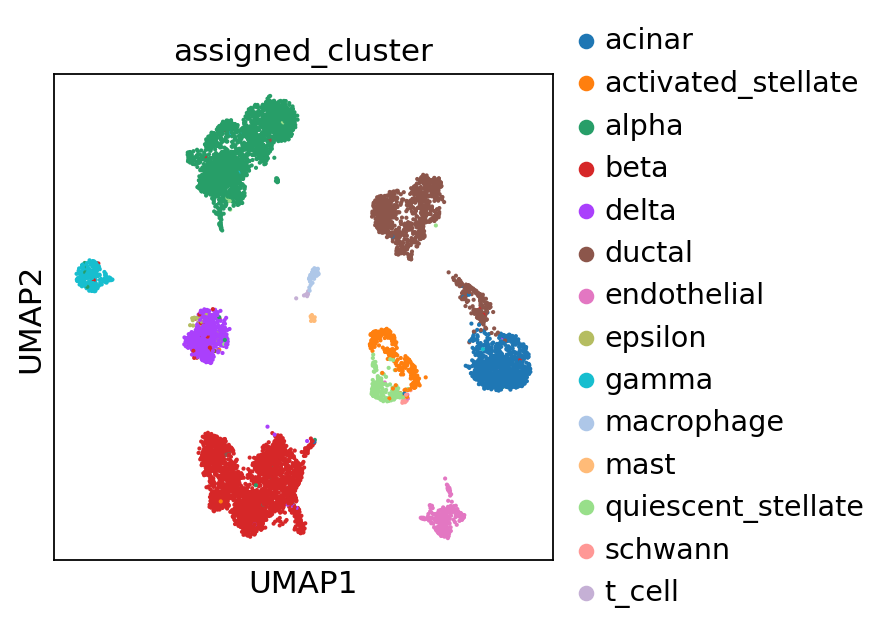

In [7]:
sc.pl.umap(adata,color='assigned_cluster',save='_figure4_raw_celltype.pdf')

# Batch correction using deepMNN

In [8]:
time_s = time.time()
corrected = correct_scanpy(adatas)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch_indices')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_deepMNN=compute_entropy(adata_result,celltype_key='assigned_cluster',batch_key='batch_indices')


tensor(0.2548, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2454, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2337, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2194, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2045, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1908, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1607, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1537, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1419, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1372, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1332, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1298, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1267, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1241, device='cuda:1', grad_fn=

... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


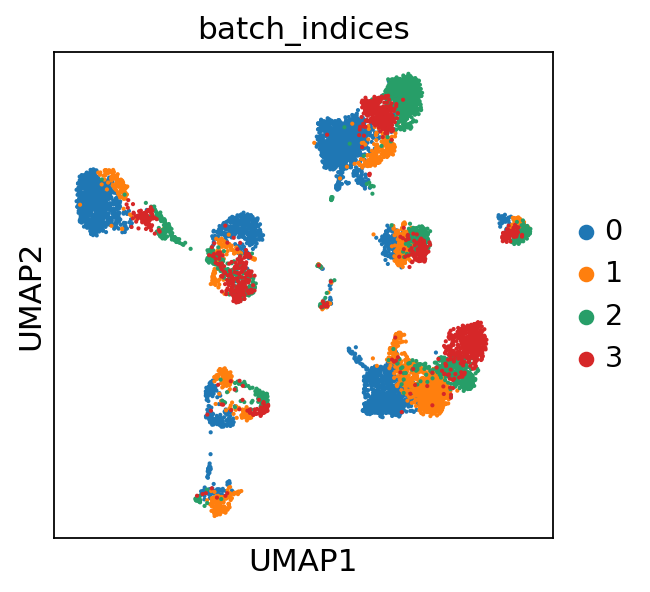

In [9]:
#adata_result.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch']]
sc.pl.umap(adata_result,color='batch_indices',save='_figure4_deepMNN_batch.pdf')

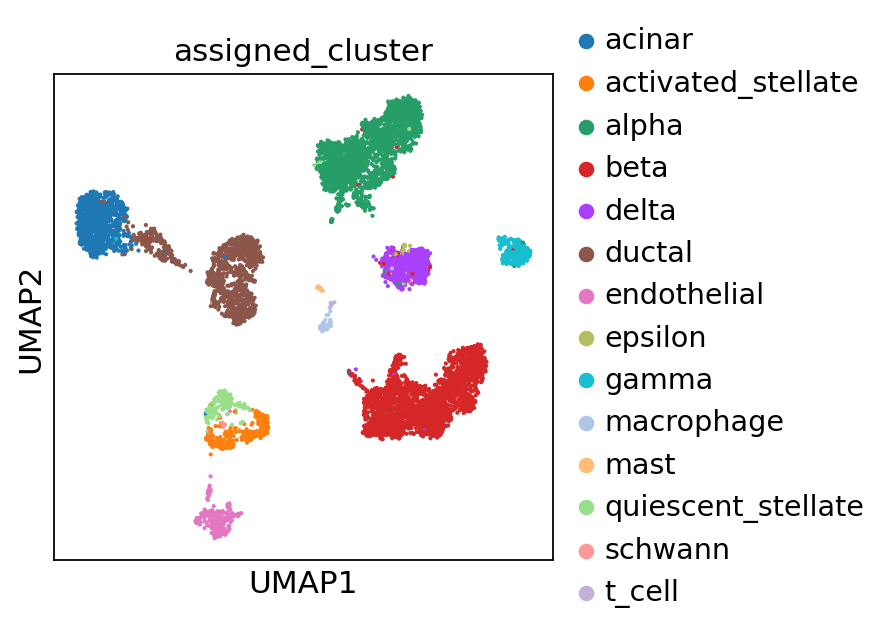

In [10]:
sc.pl.umap(adata_result,color='assigned_cluster',save='_figure4_deepMNN_celltype.pdf')

In [11]:
ann_model = scETM(adata_result.n_vars,1,device="cuda:3")
trainer = UnsupervisedTrainer(ann_model, adata_result, test_ratio=0.1)
trainer.train(n_epochs = 4000, eval_every = 1000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-12-21 20:05:06,847] INFO - scETM.logging_utils: scETM.__init__(2000, 1, device = cuda:2)
caonima

n_batches == 1, disabling batch bias


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
ann_model.get_cell_embeddings_and_nll(adata_result)

0.13448572264542336

[2021-12-18 21:38:54,041] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices', 'theta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-12-18 21:38:56,090] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:56,568] INFO - scETM.eval_utils: Resolution:   0.1	ARI:  0.2420	NMI:  0.4412	bARI:  0.0123	# labels: 8


running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.13', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:57,128] INFO - scETM.eval_utils: Resolution:  0.13	ARI:  0.2427	NMI:  0.4524	bARI:  0.0023	# labels: 10


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.19', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:57,993] INFO - scETM.eval_utils: Resolution:  0.19	ARI:  0.2084	NMI:  0.4417	bARI:  0.0064	# labels: 13


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.22', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:58,576] INFO - scETM.eval_utils: Resolution:  0.22	ARI:  0.1909	NMI:  0.4317	bARI:  0.0061	# labels: 15


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:59,131] INFO - scETM.eval_utils: Resolution:  0.25	ARI:  0.2012	NMI:  0.4338	bARI:  0.0065	# labels: 13


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.28', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:59,828] INFO - scETM.eval_utils: Resolution:  0.28	ARI:  0.1912	NMI:  0.4334	bARI:  0.0069	# labels: 15
[2021-12-18 21:39:01,847] INFO - scETM.eval_utils: delta_ASW: -0.1147
[2021-12-18 21:39:01,862] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.090859  0.078568  0.087691  0.136535
activated_stellate -0.708471 -0.636109 -0.565272 -0.509420
alpha              -0.132761 -0.051977 -0.005153  0.003485
beta               -0.163779 -0.121559 -0.102436 -0.104863
delta               0.145772  0.135739  0.077650  0.099508
ductal             -0.138216 -0.130985 -0.145658 -0.104995
endothelial        -0.676722 -0.655748 -0.480898 -0.616633
epsilon            -0.171285 -0.316594 -0.281127 -0.244054
gamma              -0.279285 -0.097508 -0.121327 -0.101193
macrophage         -0.061691 -0.125114 -0.036651  0.062619
mast               -0.761449 -0.741315 -0.611

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


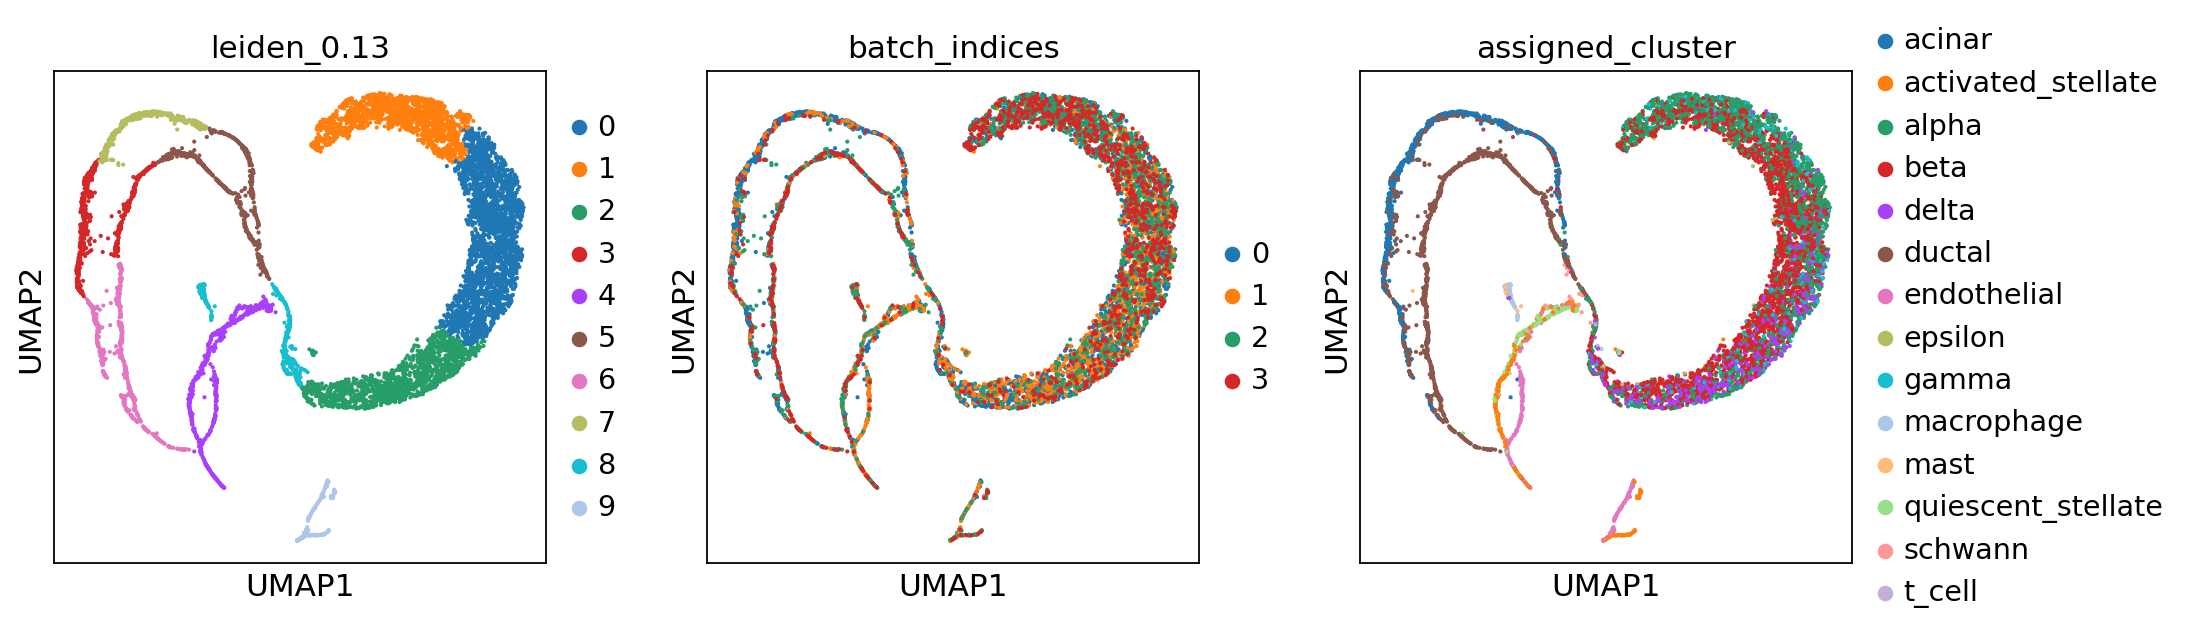

In [ ]:
result = evaluate(adata_result, resolutions = [0.08, 0.12, 0.17, 0.23, 0.3, 0.4], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")